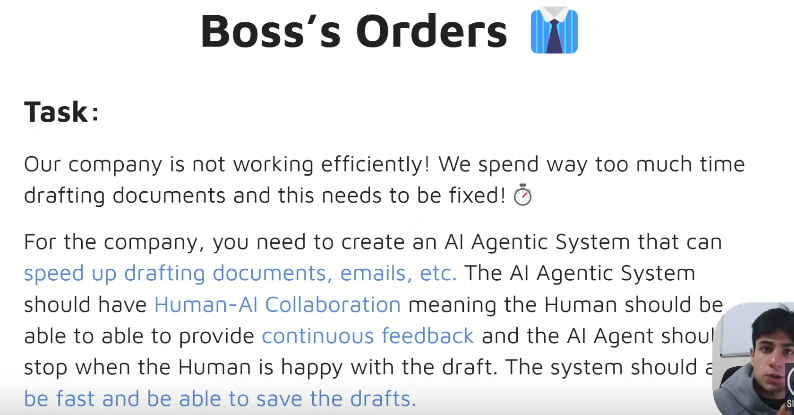

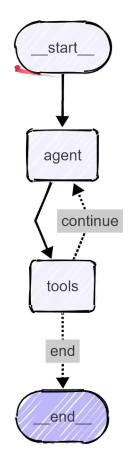

In [9]:
from typing import TypedDict, Annotated, Sequence
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode


load_dotenv()

True

In [10]:
document_content = ""

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [11]:
@tool
def update(content: str) -> str:
    """ Updates the document with the provided content """
    global document_content
    document_content = content
    return f"Updated successfully, the current content is:\n{document_content}"

@tool
def save(filename: str) -> str:
    """ Save the current document to a text file and finish the process.

    Args:
        filename: Name for the text file. 
    """
    global document_content

    if not filename.endswith(".txt"):
        filename = f"{filename}.txt"

    try:
        with open(filename, "w") as file:
            file.write(document_content)
        print(f"\n Document has been saved to: {filename}")
        return f"Document has been saved successfully to '{filename}'."
    except Exception as e:
        return f"Error saving document: {str(e)}"
    
tools = [update, save]

model = ChatOpenAI(model="gpt-4o").bind_tools(tools)


In [12]:
def our_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.
    
    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.
    
    The current document content is:{document_content}
    """)

    if not state["messages"]:
        assistant_input= "I'm ready to help you update a document. What would you like to create?"
        new_message = AIMessage(content=assistant_input)

    else:
        user_input = input("\nWhat would you like to do with the document? ")
        print(f"\n👤 USER: {user_input}")
        new_message = HumanMessage(content=user_input)
    
    all_messages = [system_prompt] + list(state["messages"]) + [new_message]

    response = model.invoke(all_messages)

    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": [new_message, response]}
    


In [13]:
def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["messages"]
    
    if not messages:
        return "continue"
    
    # This looks for the most recent tool message....
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if (isinstance(message, ToolMessage) and 
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end" # goes to the end edge which leads to the endpoint
        
    return "continue"

def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")


In [14]:
graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("agent")

graph.add_edge("agent", "tools")

graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)

app = graph.compile()

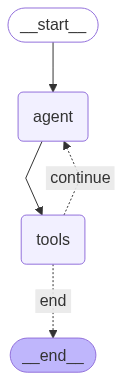

In [15]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
def run_document_agent():
    print("\n ===== DRAFTER =====")
    
    state = {"messages": []}
    
    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])
    
    print("\n ===== DRAFTER FINISHED =====")

if __name__ == "__main__":
    run_document_agent()


 ===== DRAFTER =====

🤖 AI: I'm here to help you update or create a document. Please let me know what information you'd like to add or modify.

👤 USER: write a short paragraph in the document about quantum computing

🤖 AI: 
🔧 USING TOOLS: ['update']

🛠️ TOOL RESULT: Updated successfully, the current content is:
Quantum computing is a revolutionary technology that leverages the principles of quantum mechanics to process information in fundamentally different ways from classical computers. Unlike traditional bits, which are binary and can represent 0 or 1, quantum bits, or qubits, can exist in multiple states simultaneously due to superposition. This unique capability enables quantum computers to perform complex computations at unprecedented speeds, potentially solving problems intractable for classical computers, such as large-scale factorization and optimization tasks. The development of quantum computing holds promise for significant advancements in various fields, including cryptogr